In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 3.5 MB 35.0 MB/s 
     |████████████████████████████████| 1.2 MB 38.7 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 6.8 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 50.0 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d6c3c675d9b7a1241664b09236e96858bd42930ecc35cc7248545f69444bff22
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.2 MB/s eta 0:00:011
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gzvlnphr
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-gzvlnphr
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=d34c6566ac7949d8333663a9386d6b7e8ba5630cdba354608d5c361856acfd3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-yq_2xxkg/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import clip
from sentence_transformers import SentenceTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Our sentences we like to encode
dirname = 'drive/MyDrive/europarl/'
train_path = 'train_sentences.txt'
test_path = 'test_sentences.txt'
valid_path = 'valid_sentences.txt'
train_filename = dirname + '/' + train_path
test_filename = dirname + '/' + test_path
valid_filename = dirname + '/' + valid_path

In [ ]:
train_sentences = []
with open(train_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        train_sentences.append(line)
N = len(train_sentences)
print("Number of sentences : {}".format(N))

Number of sentences : 2000


In [ ]:
for line in train_sentences:
    N = len(line.split())
    if N > 75:
      print(N)
      print(line)

In [ ]:
import re
regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
for r in regex:
  train_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), train_sentences))

In [ ]:
text = clip.tokenize(train_sentences).to(device)

In [ ]:
with torch.no_grad():
    clip_embeddings = clip_model.encode_text(text)

In [ ]:
with torch.no_grad():  
    sbert_embeddings = torch.from_numpy(sbert_model.encode(train_sentences))

In [ ]:
#Print the embeddings
for sentence, clip_embedding, sbert_embedding in zip(train_sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
    print("Sentence:", sentence)
    print("Clip Embedding: ", clip_embedding.size())
    print("Sbert Embedding: ", sbert_embedding.size())
    print("-"*10)

Sentence: You have requested a debate on this subject in the course of the next few days during this part session 
Clip Embedding:  torch.Size([512])
Sbert Embedding:  torch.Size([384])
----------


In [ ]:
class SCLIPNN(nn.Module):
    def __init__(self):
        super(SCLIPNN, self).__init__()
        self.linear1 = nn.Linear(384,100)
        self.linear2 = nn.Linear(100,512)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        return logits

In [ ]:
model = SCLIPNN().to(device)
print(model)

SCLIPNN(
  (linear1): Linear(in_features=384, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=512, bias=True)
  (relu): ReLU()
)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
losses = []
for epoch in range(150):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for i, data in enumerate(zip(sbert_embeddings, clip_embeddings)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print("Outputs and Labels size: {} - {}".format(outputs.size(),labels.size()))
        
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss)
    
    if epoch % 10 == 0:
      print("Epoch {}. Loss: {}".format(epoch+1,epoch_loss))
print('Finished Training')

Epoch 1. Loss: 473.3230978399515
Epoch 11. Loss: 88.25470303185284
Epoch 21. Loss: 83.11663280054927
Epoch 31. Loss: 79.64160005375743
Epoch 41. Loss: 76.74772431701422
Epoch 51. Loss: 74.61897502094507
Epoch 61. Loss: 73.12145369779319
Epoch 71. Loss: 71.95694405771792
Epoch 81. Loss: 70.95795603096485
Epoch 91. Loss: 70.05752982664853
Epoch 101. Loss: 69.23782672081143
Epoch 111. Loss: 68.4944240450859
Epoch 121. Loss: 67.8199481535703
Epoch 131. Loss: 67.20060380920768
Epoch 141. Loss: 66.62531717400998
Finished Training


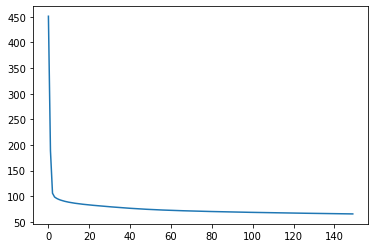

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
test_sentences = []
with open(test_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        test_sentences.append(line)
N = len(test_sentences)
print("Number of sentences : {}".format(N))

Number of sentences : 500


In [ ]:
text = clip.tokenize(test_sentences).to(device)
with torch.no_grad():
    test_clip_embeddings = clip_model.encode_text(text)

In [ ]:
with torch.no_grad():
    test_sbert_embeddings = torch.from_numpy(sbert_model.encode(test_sentences))
    prediction_embeddings = model(test_sbert_embeddings)

In [ ]:
cosines = []
for clipem, predem in zip(test_clip_embeddings, prediction_embeddings):
  cos = nn.CosineSimilarity(dim=0, eps=1e-6)
  cosine = cos(clipem, predem)
  cosines.append(cosine.item())
np_cosines = np.array(cosines)

terms = []
for i, c in enumerate(cosines):
  if np_cosines.size == 0:
    break
  best_index = np.argmax(np_cosines)
  coeff = np_cosines[best_index]/(i+1)
  terms.append(coeff)
  np_cosines = np.delete(np_cosines, best_index)
mean_reciprocal_rank = sum(terms) / len(terms)
print("Mean reciprocal mean: {}".format(mean_reciprocal_rank))

Mean reciprocal mean: 0.01306027673536154


In [ ]:
euclidean = torch.cdist(test_clip_embeddings, prediction_embeddings)
avg_euclidean = torch.mean(euclidean)
print("Average Euclidean: {}".format(avg_euclidean))

Average Euclidean: 5.124227046966553


In [ ]:
print(test_clip_embeddings[0,:7])
print('-'*20)
print(prediction_embeddings[0,:7])

tensor([ 0.0536,  0.2180,  0.0534,  0.0614, -0.1047,  0.1048,  0.2041])
--------------------
tensor([ 0.1650, -0.0245, -0.0635,  0.1133,  0.0667, -0.1089,  0.1311])


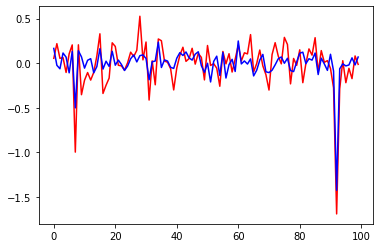

In [ ]:
plt.plot(test_clip_embeddings[0,:100],c='r')
plt.plot(prediction_embeddings[0,:100],c='b')
plt.show()